In [5]:
import os
import glob
import argparse
import textgrids
import numpy as np
from dtw_alignment import *
from distutils.util import strtobool
import pickle as pkl
import json
import re
import random
import math
import copy

import pandas as pd
import seaborn as sns
from tslearn.metrics import dtw_path
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
from scipy.stats import pearsonr
from matplotlib.colors import LogNorm
from sklearn.preprocessing import MinMaxScaler, StandardScaler


def read_pickle(pickle_path):
    # -- loading model output pickle
    with open(pickle_path, "rb") as f:
        data = pkl.load(f)

    return data

def load_model_output(exps_dir, filter_by_id, filter_by_condition, attn_scores_id='cross_embed_mha_scores', filter_wrongpred=False):
    # -- retrieving test model output paths
    model_cls_output_paths = glob.glob(f'{exps_dir}/**/model_output/test_classification.pkl', recursive=True)
    model_mha_output_paths = glob.glob(f'{exps_dir}/**/model_output/test_mha_scores.pkl', recursive=True)

    print(f'Found {len(model_cls_output_paths)} model classification output files')
    print(f'Found {len(model_mha_output_paths)} model mha output files')
    # -- loading model output
    sample_ids = []
    target_attn_scores = []
    pred_labels = []
    for model_cls_output_path in model_cls_output_paths:
        batch_cls_model_outputs = read_pickle(model_cls_output_path)
        
        for s, pred, label, sample_id, attn_scores in zip(
            batch_cls_model_outputs['sample_id'],
            batch_cls_model_outputs['preds'],
            batch_cls_model_outputs['labels'],
            batch_cls_model_outputs['sample_id'],
            batch_cls_model_outputs[attn_scores_id],
        ):
            # print(f'Processing sample: {sample_id}, label: {label}, pred: {pred}; Keys in batch_cls_model_outputs: {batch_cls_model_outputs.keys()}')
            # print(f'  Attn scores shape: {np.squeeze(attn_scores, axis=0).shape}')
            # -- filtering by subset, or specific sample
            if filter_by_id in sample_id:
                if filter_by_condition == label:
                    if filter_wrongpred:
                        if pred != label:
                            sample_ids.append( sample_id )
                            loaded_attn_scores = np.squeeze(attn_scores, axis=0)
                            row_sums = np.sum(np.abs(loaded_attn_scores), axis=1)
                            valid_row = row_sums > 1e-10
                            attention_scores_masked = loaded_attn_scores[valid_row, :]
                            
                            target_attn_scores.append( attention_scores_masked )
                            pred_labels.append(pred)
                    else:
                        if pred == label:
                            sample_ids.append( sample_id )
                            loaded_attn_scores = np.squeeze(attn_scores, axis=0)
                            row_sums = np.sum(np.abs(loaded_attn_scores), axis=1)
                            valid_row = row_sums > 1e-10
                            attention_scores_masked = loaded_attn_scores[valid_row, :]
        # 创建有效区域的掩码
                            target_attn_scores.append( attention_scores_masked )
                            pred_labels.append(pred)
                        

    assert len(target_attn_scores) > 0, f'\nNo ID filter matching found for: {filter_by_id}'

    # -- getting metadata regarding informed speech feaures IDs
    # informed_metadata = batch_cls_model_outputs['informed_metadata']
    return sample_ids, target_attn_scores, pred_labels

def get_informed_highlevel_group(current_idx, informed_metadata_bounds):
    for type_inf, (start, end) in informed_metadata_bounds.items():
        if current_idx >= start and current_idx < end:
            return type_inf


exps_dir = '/home/yzhong/gits/interpretable-pd/exps/pcgita_splits_10foldnew/cross_token_newcate/allsent/'
output_dir = '/home/yzhong/gits/interpretable-pd/plots/test/'
filter_by_id = ''

# -- creating output directory
os.makedirs(output_dir, exist_ok=True)
for subdir in ['figures', 'stats']:
    os.makedirs(os.path.join(output_dir, subdir), exist_ok=True)

filter_by_condition = 0

hc_sample_ids, hc_attn_scores, hc_pred_labels = load_model_output(
    exps_dir,
    filter_by_id,
    filter_by_condition,
    attn_scores_id='attn_scores',
)

print(f'\nConsidering {len(hc_attn_scores)} {"HC" if filter_by_condition == 0 else "PD"} samples based on the ID filter: {filter_by_id}')

filter_by_condition = 1
pd_sample_ids, pd_attn_scores, pd_pred_labels = load_model_output(
    exps_dir,
    filter_by_id,
    filter_by_condition,
    attn_scores_id='attn_scores',
    filter_wrongpred=True,
)   
print(f'\nConsidering {len(pd_attn_scores)} {"HC" if filter_by_condition == 0 else "PD"} samples based on the ID filter: {filter_by_id}')



Found 50 model classification output files
Found 0 model mha output files

Considering 3425 HC samples based on the ID filter: 
Found 50 model classification output files
Found 0 model mha output files

Considering 966 PD samples based on the ID filter: 


In [18]:
hc_pred_labels

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [6]:
# 检查注意力分数是否已经经过softmax处理
def check_softmax(attention_scores, axis=1, tolerance=1e-5, padding_mask=None):
    """
    检查注意力分数是否已经过softmax处理，并排除padding区域
    
    参数:
        attention_scores: 注意力分数矩阵
        axis: 求和的轴，1表示行和，0表示列和
        tolerance: 允许的误差范围
        padding_mask: 指示padding位置的掩码，None表示通过零值自动检测
    
    返回:
        is_softmax: 是否已经过softmax处理
    """
    # 自动识别padding区域（假设填充部分的值全为0）
    if padding_mask is None:
        # 假设行或列全为0的是padding
        row_sums = np.sum(np.abs(attention_scores), axis=1)
        col_sums = np.sum(np.abs(attention_scores), axis=0)
        valid_rows = row_sums > 1e-10
        valid_cols = col_sums > 1e-10
        
        # 创建有效区域的掩码
        attention_scores_masked = attention_scores[valid_rows, :][:, valid_cols]
    else:
        # 使用提供的掩码
        attention_scores_masked = attention_scores[~padding_mask, :][:, ~padding_mask]
    
    # 如果掩码后矩阵为空，则直接返回
    if attention_scores_masked.size == 0:
        print("警告：掩码后注意力矩阵为空！")
        return {
            'is_softmax': False,
            'sum_values': np.array([]),
            'min_sum': 0,
            'max_sum': 0,
            'mean_sum': 0,
            'std_sum': 0,
            'masked_shape': (0, 0)
        }
    
    # 计算去除padding后的行和或列和
    sum_values = np.sum(attention_scores_masked, axis=axis)
    is_close_to_one = np.allclose(sum_values, 1.0, rtol=tolerance)
    
    return {
        'is_softmax': is_close_to_one,
        'sum_values': sum_values,
        'min_sum': np.min(sum_values) if sum_values.size > 0 else 0,
        'max_sum': np.max(sum_values) if sum_values.size > 0 else 0,
        'mean_sum': np.mean(sum_values) if sum_values.size > 0 else 0,
        'std_sum': np.std(sum_values) if sum_values.size > 0 else 0,
        'masked_shape': attention_scores_masked.shape
    }

# 对HC样本和PD样本分别进行检查
def check_all_samples(sample_scores, sample_name):
    print(f"\n检查{sample_name}样本:")
    
    # 检查行和(axis=1)
    row_results = []
    for i, score in enumerate(sample_scores):
        result = check_softmax(score, axis=1)
        row_results.append(result)
        
    row_softmax_count = sum(r['is_softmax'] for r in row_results)
    print(f"行和检查: {row_softmax_count}/{len(sample_scores)} 个样本的行和约等于1")
    
    # 计算所有样本行和的平均值、最小值、最大值
    all_mean_sums = [r['mean_sum'] for r in row_results]
    print(f"所有样本行和的平均值: {np.median(all_mean_sums):.6f}")
    print(f"所有样本行和的最小值: {np.min([r['min_sum'] for r in row_results]):.6f}")
    print(f"所有样本行和的最大值: {np.max([r['max_sum'] for r in row_results]):.6f}")

# 检查HC样本
if len(hc_attn_scores) > 0:
    check_all_samples(hc_attn_scores, "HC")
    

# 检查PD样本
if len(pd_attn_scores) > 0:
    check_all_samples(pd_attn_scores, "PD")
    



检查HC样本:
行和检查: 3425/3425 个样本的行和约等于1
所有样本行和的平均值: 1.000000
所有样本行和的最小值: 1.000000
所有样本行和的最大值: 1.000000

检查PD样本:
行和检查: 966/966 个样本的行和约等于1
所有样本行和的平均值: 1.000000
所有样本行和的最小值: 1.000000
所有样本行和的最大值: 1.000000



可视化PD样本的注意力维度 - 柱状图:
原始样本形状: (139, 5)
去除填充后的样本形状: (139, 5)
有效样本的平均分数形状: (139, 5)
平均分数: [0.04183915 0.67615936 0.23188685 0.0280641  0.02205054]


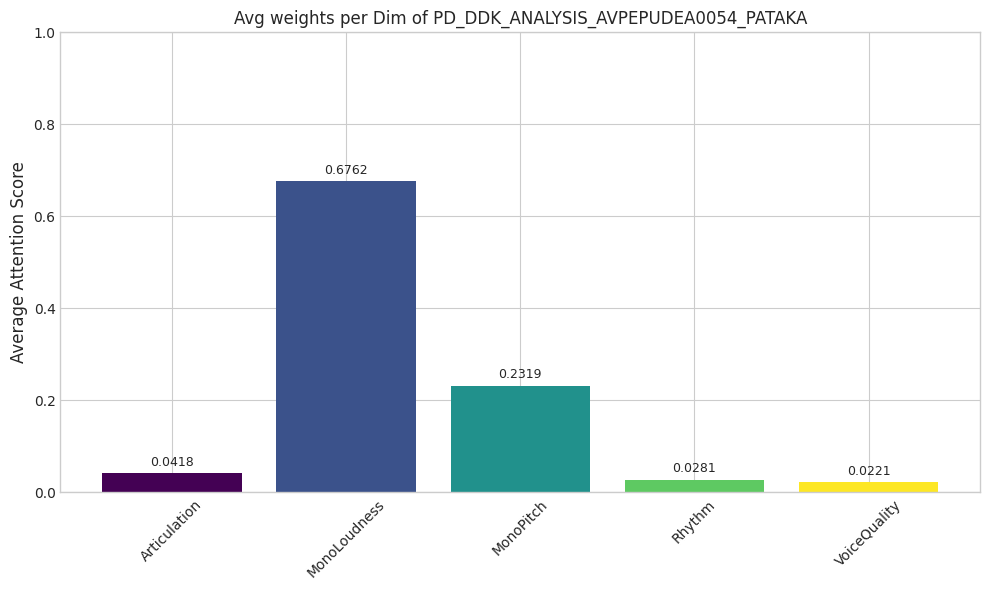

警告: 指定的样本ID 'PD_DDK_ANALYSIS_AVPEPUDEA0005_PAKATA' 不在样本列表中。


NameError: name 'idx' is not defined

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator

def visualize_attention_bar_chart(attn_score, sample_id=None, dimension_names=None, output_path=None):
    """
    可视化单个样本的维度注意力分数柱状图
    
    参数:
        attn_score: 形状为(T, D)的单个样本注意力分数矩阵
        sample_id: 样本ID，用于在标题中显示。可以是字符串或整数索引
        dimension_names: 维度名称列表，默认为['Articulation', 'MonoLoudness', 'MonoPitch', 'Rhythm', 'VoiceQuality']
        output_path: 输出图像路径，如果为None则显示图像
    """
    if dimension_names is None:
        dimension_names = ['Articulation', 'MonoLoudness', 'MonoPitch', 'Rhythm', 'VoiceQuality']
    
    # 识别非零区域（去除填充）
    row_sums = np.sum(np.abs(attn_score), axis=1)
    valid_rows = row_sums > 1e-10
    
    # 去除填充区域
    valid_sample = attn_score[valid_rows, :]
    
    print(f"原始样本形状: {attn_score.shape}")
    print(f"去除填充后的样本形状: {valid_sample.shape}")
    
    T, num_dimensions = valid_sample.shape
    
    # 确保维度名称数量匹配
    if len(dimension_names) != num_dimensions:
        print(f"警告: 维度名称数量({len(dimension_names)})与注意力分数维度({num_dimensions})不匹配")
        dimension_names = [f"Dimension {i+1}" for i in range(num_dimensions)]
    
    # 设置绘图风格
    plt.style.use('seaborn-v0_8-whitegrid')
    colors = plt.cm.viridis(np.linspace(0, 1, num_dimensions))
    
    # 图1: 各维度平均注意力分数的柱状图
    plt.figure(figsize=(10, 6))
    
    # 计算每个维度的平均分数
    print(f"有效样本的平均分数形状: {valid_sample.shape}")
    avg_scores = np.mean(valid_sample, axis=0)
    print(f"平均分数: {avg_scores}")
    
    # 创建柱状图
    bars = plt.bar(dimension_names, avg_scores, color=colors)
    
    # 在每个柱状上方标注具体数值
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                 f'{height:.4f}', ha='center', va='bottom', fontsize=9)
    
    # 设置标题 - 根据sample_id的类型决定标题文本
    if sample_id is not None:
        plt.title(f'Avg weights per Dim of {sample_id}', fontsize=12)
    else:
        plt.title('Average Attention Weights per Dimension', fontsize=12)
    
    plt.ylabel('Average Attention Score', fontsize=12)
    plt.ylim(0, 1.0)  # 固定y轴范围为0-1
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    # 保存或显示图像
    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    return avg_scores  # 返回平均分数，方便进一步分析


def visualize_attention_time_series(attn_score, dimension_names=None, window_size=20, output_path=None):
    """
    可视化单个样本的注意力分数随时间变化的折线图
    
    参数:
        attn_score: 形状为(T, D)的单个样本注意力分数矩阵
        dimension_names: 维度名称列表，默认为['Articulation', 'MonoLoudness', 'MonoPitch', 'Rhythm', 'VoiceQuality']
        window_size: 时间窗口的大小，默认为20个时间步
        output_path: 输出图像路径，如果为None则显示图像
    """
    if dimension_names is None:
        dimension_names = ['Articulation', 'MonoLoudness', 'MonoPitch', 'Rhythm', 'VoiceQuality']
    
    # 识别非零区域（去除填充）
    row_sums = np.sum(np.abs(attn_score), axis=1)
    valid_rows = row_sums > 1e-10
    
    # 去除填充区域
    valid_sample = attn_score[valid_rows, :]
    
    T, num_dimensions = valid_sample.shape
    
    # 确保维度名称数量匹配
    if len(dimension_names) != num_dimensions:
        print(f"警告: 维度名称数量({len(dimension_names)})与注意力分数维度({num_dimensions})不匹配")
        dimension_names = [f"Dimension {i+1}" for i in range(num_dimensions)]
    
    # 设置绘图风格
    plt.style.use('seaborn-v0_8-whitegrid')
    colors = plt.cm.viridis(np.linspace(0, 1, num_dimensions))
    
    # 图2: 随时间变化的注意力分数折线图
    plt.figure(figsize=(12, 7))
    
    # 计算需要多少个窗口
    num_windows = max(1, T // window_size)
    
    # 初始化结果数组
    windowed_scores = np.zeros((num_windows, num_dimensions))
    
    # 计算每个窗口的平均分数
    for i in range(num_windows):
        start_idx = i * window_size
        end_idx = min(start_idx + window_size, T)
        windowed_scores[i] = np.mean(valid_sample[start_idx:end_idx], axis=0)
    
    # 绘制折线图
    x_ticks = np.arange(num_windows) + 1
    
    for i in range(num_dimensions):
        plt.plot(x_ticks, windowed_scores[:, i], 
                 marker='o', linestyle='-', linewidth=2, color=colors[i],
                 label=dimension_names[i])
    
    plt.title(f'Attention Scores Over Time (Averaged per {window_size} time steps)', fontsize=14)
    plt.xlabel(f'Time Window (each represents {window_size} time steps)', fontsize=12)
    plt.ylabel('Average Attention Score', fontsize=12)
    plt.legend(loc='best')
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # 设置x轴为整数刻度
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    
    # 如果窗口数量较多，可以调整x轴刻度
    if num_windows > 10:
        plt.xticks(np.arange(1, num_windows+1, num_windows//10))
    
    plt.tight_layout()
    
    # 保存或显示图像
    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    return windowed_scores  # 返回时间序列数据，方便进一步分析

# # 使用示例
# if len(hc_attn_scores) > 0:
#     print("\n可视化HC样本的注意力维度 - 柱状图:")
#     # 选择第3个样本进行可视化
#     sample_index = 22
#     visualize_attention_bar_chart(
#         hc_attn_scores[sample_index], 
#         hc_sample_ids[sample_index],
#         output_path=os.path.join(output_dir, 'figures', f'hc_sample_{hc_sample_ids[sample_index]}_bar.png')
#     )
    
    # print("\n可视化HC样本的注意力维度 - 时间序列:")
    # visualize_attention_time_series(
    #     hc_attn_scores[sample_index],
    #     window_size=20,
    #     output_path=os.path.join(output_dir, 'figures', f'hc_sample_{sample_index}_time.png')
    # )
    
if len(pd_attn_scores) > 0:
    print("\n可视化PD样本的注意力维度 - 柱状图:")
    # 选择第1个样本进行可视化
    # 使用样本ID列表中的ID
    sample_index = 20
    visualize_attention_bar_chart(
        pd_attn_scores[sample_index],
        sample_id=pd_sample_ids[sample_index],
        output_path=os.path.join(output_dir, 'figures', f'pd_sample_{pd_sample_ids[sample_index]}_bar.png')
    )
        
    # 直接指定sample_id
    # specify_id = 'PD_DDK_ANALYSIS_AVPEPUDEA0005_PAKATA'
    # if specify_id not in pd_sample_ids:
    #     print(f"警告: 指定的样本ID '{specify_id}' 不在样本列表中。")
    # else:
    #     idx = pd_sample_ids.index(specify_id)
    #     print(f"找到样本ID '{specify_id}' 的索引: {idx}")
    #     print(pd_sample_ids[idx])
    # visualize_attention_bar_chart(
    #     pd_attn_scores[idx],
    #     sample_id=specify_id,
    #     output_path=os.path.join(output_dir, 'figures', f'pd_score_oneutt_{specify_id}.png')
    
    # print("\n可视化PD样本的注意力维度 - 时间序列:")
    # visualize_attention_time_series(
    #     pd_attn_scores[sample_index],
    #     window_size=20,
    #     output_path=os.path.join(output_dir, 'figures', f'pd_sample_{sample_index}_time.png')
    # )


可视化所有HC样本的注意力维度平均值:
样本数量: 3425
维度数量: 5
总平均分数: [0.28850422 0.16664777 0.15295367 0.17103336 0.22086097]
标准差: [0.17870617 0.16015571 0.14506634 0.14640533 0.16244263]


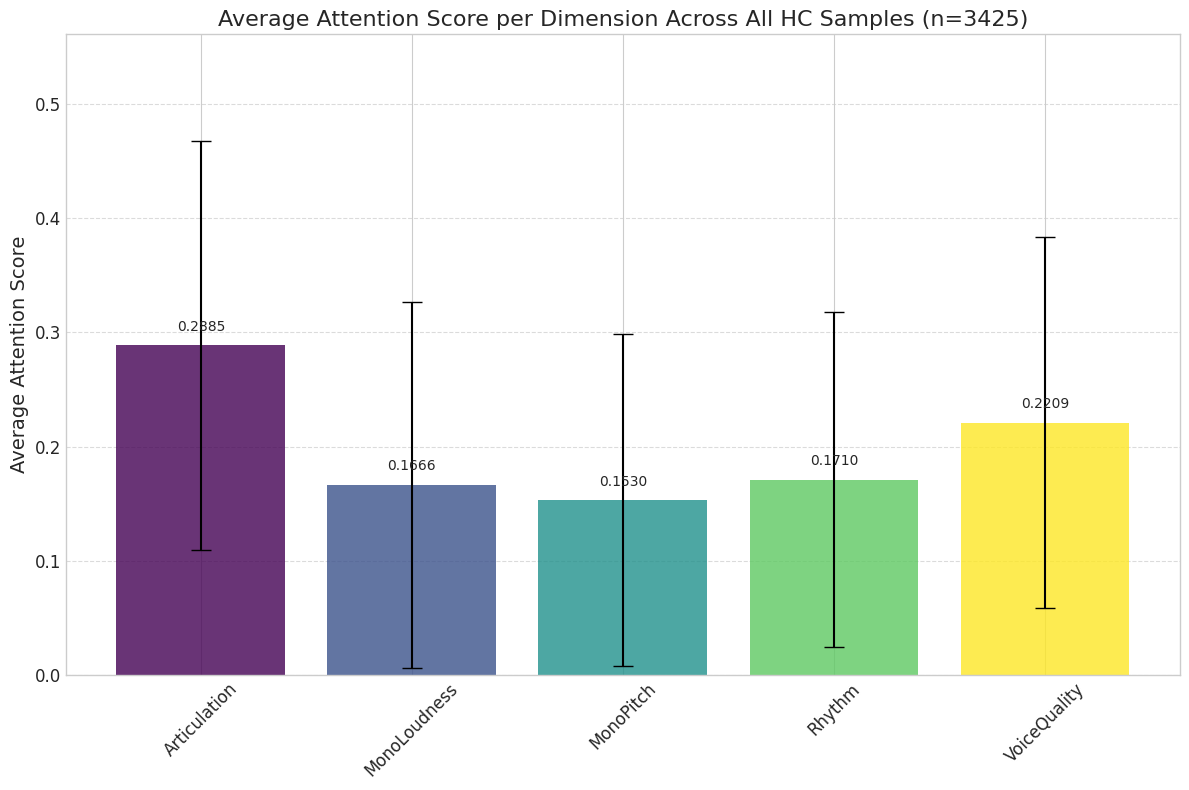


可视化所有PD样本的注意力维度平均值:
样本数量: 3284
维度数量: 5
总平均分数: [0.3115445  0.06075594 0.1195586  0.15343905 0.3547019 ]
标准差: [0.28536147 0.06987993 0.15647639 0.21617648 0.29795309]


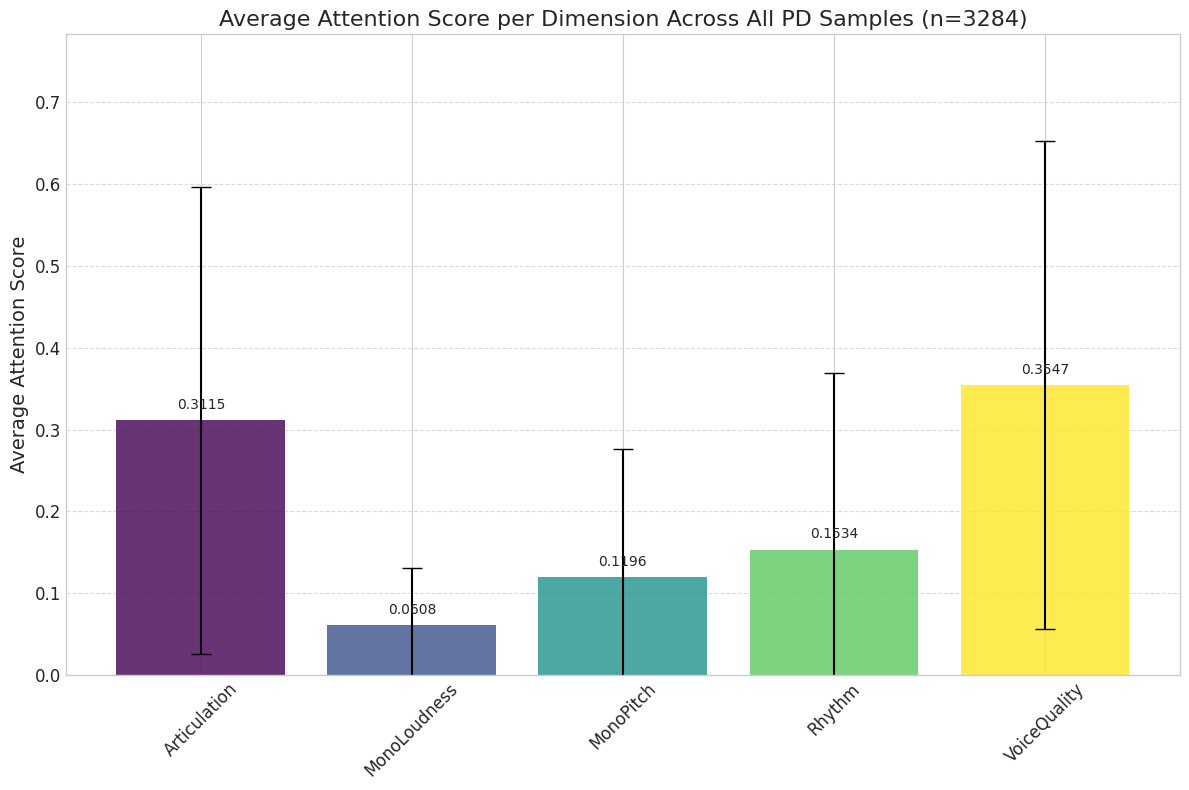

In [21]:
def visualize_all_samples_average_attention(attn_scores_list, dimension_names=None, sample_type="HC", output_path=None):
    """
    可视化所有样本的维度注意力分数平均值的柱状图
    
    参数:
        attn_scores_list: 包含多个形状为(T, D)的注意力分数矩阵的列表
        dimension_names: 维度名称列表，默认为['Articulation', 'MonoLoudness', 'MonoPitch', 'Rhythm', 'VoiceQuality']
        sample_type: 样本类型名称，用于标题
        output_path: 输出图像路径，如果为None则显示图像
    """
    if dimension_names is None:
        dimension_names = ['Articulation', 'MonoLoudness', 'MonoPitch', 'Rhythm', 'VoiceQuality']
    
    # 收集所有样本的平均分数
    all_avg_scores = []
    
    for i, attn_score in enumerate(attn_scores_list):
        # 识别非零区域（去除填充）
        row_sums = np.sum(np.abs(attn_score), axis=1)
        valid_rows = row_sums > 1e-10
        
        # 去除填充区域
        valid_sample = attn_score[valid_rows, :]
        
        # 计算单个样本每个维度的平均分数
        avg_scores = np.mean(valid_sample, axis=0)
        all_avg_scores.append(avg_scores)
    
    # 将所有样本的平均分数转换为数组
    all_avg_scores = np.array(all_avg_scores)
    
    # 计算所有样本的总平均分数
    overall_avg_scores = np.mean(all_avg_scores, axis=0)
    
    # 计算所有样本的标准差
    overall_std_scores = np.std(all_avg_scores, axis=0)
    
    print(f"样本数量: {len(attn_scores_list)}")
    print(f"维度数量: {len(dimension_names)}")
    print(f"总平均分数: {overall_avg_scores}")
    print(f"标准差: {overall_std_scores}")
    
    # 设置绘图风格
    plt.style.use('seaborn-v0_8-whitegrid')
    colors = plt.cm.viridis(np.linspace(0, 1, len(dimension_names)))
    
    # 创建图形
    plt.figure(figsize=(12, 8))
    
    # 创建柱状图
    bars = plt.bar(dimension_names, overall_avg_scores, color=colors, yerr=overall_std_scores, 
                  capsize=7, alpha=0.8, ecolor='black')
    
    # 在每个柱状上方标注具体数值
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.4f}', ha='center', va='bottom', fontsize=10)
    
    plt.title(f'Average Attention Score per Dimension Across All {sample_type} Samples (n={len(attn_scores_list)})', fontsize=16)
    plt.ylabel('Average Attention Score', fontsize=14)
    plt.ylim(0, np.max(overall_avg_scores + overall_std_scores) * 1.2)  # 设置合适的y轴范围
    plt.xticks(rotation=45, fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    
    # 保存或显示图像
    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    return overall_avg_scores, overall_std_scores

# 可视化所有HC样本
if len(hc_attn_scores) > 0:
    print("\n可视化所有HC样本的注意力维度平均值:")
    hc_avg, hc_std = visualize_all_samples_average_attention(
        hc_attn_scores,
        sample_type="HC",
        output_path=os.path.join(output_dir, 'figures', 'all_hc_samples_avg_bar.png')
    )
    
# 可视化所有PD样本
if len(pd_attn_scores) > 0:
    print("\n可视化所有PD样本的注意力维度平均值:")
    pd_avg, pd_std = visualize_all_samples_average_attention(
        pd_attn_scores,
        sample_type="PD",
        output_path=os.path.join(output_dir, 'figures', 'all_pd_samples_avg_bar.png')
    )


比较指定的PD样本与HC基准:

分析PD样本 PD_DDK_ANALYSIS_AVPEPUDEA0020_PETAKA:
PD sample original shape: (339, 5)
PD sample shape after padding removal: (339, 5)


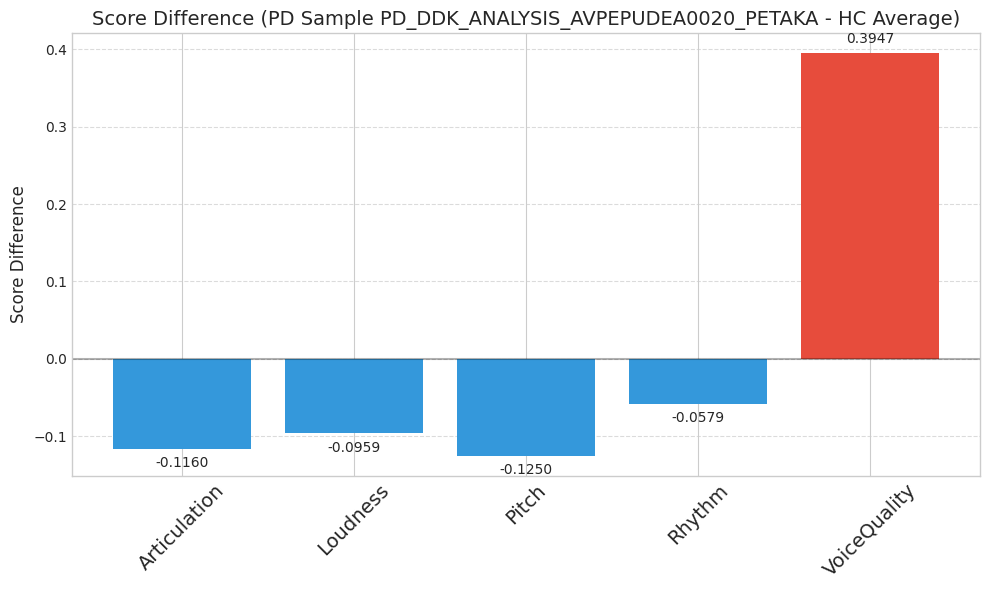

In [22]:

def visualize_attention_difference(pd_attn_score, hc_avg, dimension_names=None, sample_id=None, output_path=None):
    """
    Visualize the difference in attention scores between a single PD sample and the HC average
    
    Parameters:
        pd_attn_score: Attention score matrix for a single PD sample with shape (T, D)
        hc_avg: Average attention score for HC samples with shape (D,)
        dimension_names: List of dimension names
        sample_id: ID of the PD sample for title display
        output_path: Path to save the output image
    """
    if dimension_names is None:
        dimension_names = ['Articulation', 'MonoLoudness', 'MonoPitch', 'Rhythm', 'VoiceQuality']
    
    # Identify non-zero regions (remove padding)
    row_sums = np.sum(np.abs(pd_attn_score), axis=1)
    valid_rows = row_sums > 1e-10
    
    # Remove padding areas
    valid_sample = pd_attn_score[valid_rows, :]
    
    print(f"PD sample original shape: {pd_attn_score.shape}")
    print(f"PD sample shape after padding removal: {valid_sample.shape}")
    
    # Calculate average attention scores for the PD sample
    pd_avg = np.mean(valid_sample, axis=0)
    
    # Calculate difference
    diff = pd_avg - hc_avg
    
    # Set color mapping - red for PD>HC, blue for HC>PD
    colors = ['#3498db' if d < 0 else '#e74c3c' for d in diff]
    
    # Create figure
    plt.figure(figsize=(10, 6))
    
    # Create difference bar chart
    bars = plt.bar(dimension_names, diff, color=colors)
    
    # Add value labels on the bars
    for bar in bars:
        height = bar.get_height()
        # If negative, show text below the bar
        if height < 0:
            plt.text(bar.get_x() + bar.get_width()/2., height - 0.01,
                    f'{height:.4f}', ha='center', va='top', fontsize=10)
        else:
            plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{height:.4f}', ha='center', va='bottom', fontsize=10)
    
    plt.title(f'Score Difference (PD Sample {sample_id if sample_id else ""} - HC Average)', fontsize=14)
    plt.ylabel('Score Difference', fontsize=12)
    plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    plt.xticks(rotation=45, fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add shaded area for HC standard deviation if available
    # if hasattr(hc_std, 'shape') and hc_std.shape == hc_avg.shape:
    #     for i, (avg, std) in enumerate(zip(hc_avg, hc_std)):
    #         plt.fill_between([i-0.4, i+0.4], [-std, -std], [std, std],
    #                        color='gray', alpha=0.3)
    
    plt.tight_layout()
    
    # Save or display the image
    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    return pd_avg, diff
# 为多个PD样本创建HC基准与PD样本差异对比图
def visualize_multiple_pd_samples(pd_attn_scores, pd_sample_ids, hc_avg, hc_std, dimension_names=None, 
                                 num_samples=5, output_dir=output_dir, specified_samples=None):
    """
    从PD样本池中选择几个进行与HC平均值的对比
    
    参数:
        pd_attn_scores: PD样本注意力分数列表
        pd_sample_ids: PD样本ID列表
        hc_avg: HC样本的平均注意力分数
        hc_std: HC样本的标准差
        dimension_names: 维度名称列表
        num_samples: 随机选择的样本数量（如果不指定specific_samples）
        output_dir: 输出目录
        specified_samples: 可选，指定要可视化的样本ID列表或单个样本ID
    """
    if dimension_names is None:
        # dimension_names = ['Articulation', 'MonoLoudness', 'MonoPitch', 'Rhythm', 'VoiceQuality']
        dimension_names = ['Articulation', 'Loudness', 'Pitch', 'Rhythm', 'VoiceQuality']

    
    # 处理用户指定的样本
    if specified_samples is not None:
        # 将单个样本ID转换为列表
        if isinstance(specified_samples, str):
            specified_samples = [specified_samples]
        
        # 查找指定样本ID对应的索引
        specified_indices = []
        for sample_id in specified_samples:
            if sample_id in pd_sample_ids:
                idx = pd_sample_ids.index(sample_id)
                specified_indices.append(idx)
            else:
                print(f"警告: 未找到样本 {sample_id}，将跳过该样本")
        
        # 如果没有找到任何指定的样本，回退到随机选择
        if not specified_indices:
            print("未找到任何指定的样本，将随机选择样本")
            if num_samples < len(pd_attn_scores):
                indices = np.random.choice(len(pd_attn_scores), num_samples, replace=False)
            else:
                indices = range(len(pd_attn_scores))
        else:
            indices = specified_indices
    else:
        # 随机选择样本（如果不是指定的）
        if num_samples < len(pd_attn_scores):
            indices = np.random.choice(len(pd_attn_scores), num_samples, replace=False)
        else:
            indices = range(len(pd_attn_scores))
    
    # 为每个样本创建对比图
    pd_avg_list = []
    for i in indices:
        sample_id = pd_sample_ids[i] if i < len(pd_sample_ids) else f"Sample_{i}"
        print(f"\n分析PD样本 {sample_id}:")
        
        pd_avg, diff = visualize_attention_difference(
            pd_attn_scores[i], 
            hc_avg,
            dimension_names=dimension_names,
            sample_id=sample_id,
            output_path=os.path.join(output_dir, 'figures', f'pd_vs_hc_diff_{sample_id}.png')
        )
        pd_avg_list.append(pd_avg)
    
    # 如果有多个PD样本，计算它们的平均值并对比HC
    if len(pd_avg_list) > 1:
        pd_all_avg = np.mean(np.array(pd_avg_list), axis=0)
        pd_all_std = np.std(np.array(pd_avg_list), axis=0)
        
        # 创建HC vs PD(平均)的总体对比图
        plt.figure(figsize=(14, 8))
        
        # 分组柱状图
        x = np.arange(len(dimension_names))
        width = 0.35
        
        # 设置y轴范围为0-1
        plt.ylim(0, 1.0)
        
        plt.bar(x - width/2, hc_avg, width, label='HC Average', color='#3498db', yerr=hc_std, capsize=5)
        plt.bar(x + width/2, pd_all_avg, width, label=f'PD Average (n={len(pd_avg_list)})', color='#e74c3c', yerr=pd_all_std, capsize=5)
        
        plt.title(f'Comparison of Average Attention Scores: HC vs PD', fontsize=16)
        plt.ylabel('Average Attention Score', fontsize=14)
        plt.xticks(x, dimension_names, rotation=45, fontsize=14)
        plt.legend(fontsize=12)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        
        # 文件名中增加样本信息
        if specified_samples and len(specified_samples) <= 3:
            sample_info = "_".join(specified_samples)
            output_filename = f'hc_vs_pd_comparison_{sample_info}.png'
        else:
            output_filename = 'hc_vs_pd_avg_comparison.png'
        
        plt.savefig(os.path.join(output_dir, 'figures', output_filename), dpi=300, bbox_inches='tight')
        plt.show()

# # 示例1: 随机选择样本
# if len(pd_attn_scores) > 0 and 'hc_avg' in locals() and 'hc_std' in locals():
#     print("\n比较PD样本与HC基准:")
#     visualize_multiple_pd_samples(
#         pd_attn_scores,
#         pd_sample_ids,
#         hc_avg,
#         hc_std,
#         num_samples=10  # 随机选择3个样本
#     )

# 示例2: 指定单个样本ID
if len(pd_attn_scores) > 0 and 'hc_avg' in locals() and 'hc_std' in locals():
    print("\n比较指定的PD样本与HC基准:")
    visualize_multiple_pd_samples(
        pd_attn_scores,
        pd_sample_ids,
        hc_avg,
        hc_std,
        specified_samples="PD_DDK_ANALYSIS_AVPEPUDEA0020_PETAKA"  # 指定单个样本ID
    )

# 示例3: 指定多个样本ID
# if len(pd_attn_scores) > 0 and 'hc_avg' in locals() and 'hc_std' in locals():
#     print("\n比较多个指定的PD样本与HC基准:")
#     visualize_multiple_pd_samples(
#         pd_attn_scores,
#         pd_sample_ids,
#         hc_avg,
#         hc_std,
#         specified_samples=["P091_065", "P102_013", "P107_098"]  # 指定多个样本ID
#     )


计算PD受试者平均注意力权重和标准差:
找到49个不同的受试者
处理受试者 AVPEPUDEA0027，包含7个样本
处理受试者 AVPEPUDEA0049，包含85个样本
处理受试者 AVPEPUDEA0003，包含85个样本
处理受试者 AVPEPUDEA0001，包含64个样本
处理受试者 AVPEPUDEA0016，包含74个样本
处理受试者 AVPEPUDEA0057，包含83个样本
处理受试者 AVPEPUDEA0008，包含34个样本
处理受试者 AVPEPUDEA0002，包含52个样本
处理受试者 AVPEPUDEA0031，包含84个样本
处理受试者 AVPEPUDEA0055，包含85个样本
处理受试者 AVPEPUDEA0023，包含14个样本
处理受试者 AVPEPUDEA0051，包含85个样本
处理受试者 AVPEPUDEA0026，包含82个样本
处理受试者 AVPEPUDEA0039，包含85个样本
处理受试者 AVPEPUDEA0052，包含84个样本
处理受试者 AVPEPUDEA0017，包含83个样本
处理受试者 AVPEPUDEA0058，包含7个样本
处理受试者 AVPEPUDEA0045，包含84个样本
处理受试者 AVPEPUDEA0021，包含82个样本
处理受试者 AVPEPUDEA0056，包含73个样本
处理受试者 AVPEPUDEA0011，包含15个样本
处理受试者 AVPEPUDEA0020，包含78个样本
处理受试者 AVPEPUDEA0025，包含77个样本
处理受试者 AVPEPUDEA0037，包含69个样本
处理受试者 AVPEPUDEA0006，包含69个样本
处理受试者 AVPEPUDEA0010，包含55个样本
处理受试者 AVPEPUDEA0043，包含85个样本
处理受试者 AVPEPUDEA0046，包含84个样本
处理受试者 AVPEPUDEA0035，包含70个样本
处理受试者 AVPEPUDEA0042，包含39个样本
处理受试者 AVPEPUDEA0041，包含80个样本
处理受试者 AVPEPUDEA0034，包含58个样本
处理受试者 AVPEPUDEA0032，包含67个样本
处理受试者 AVPEPUDEA0048，包含78个样本
处理受试者 AVPEPUDEA00

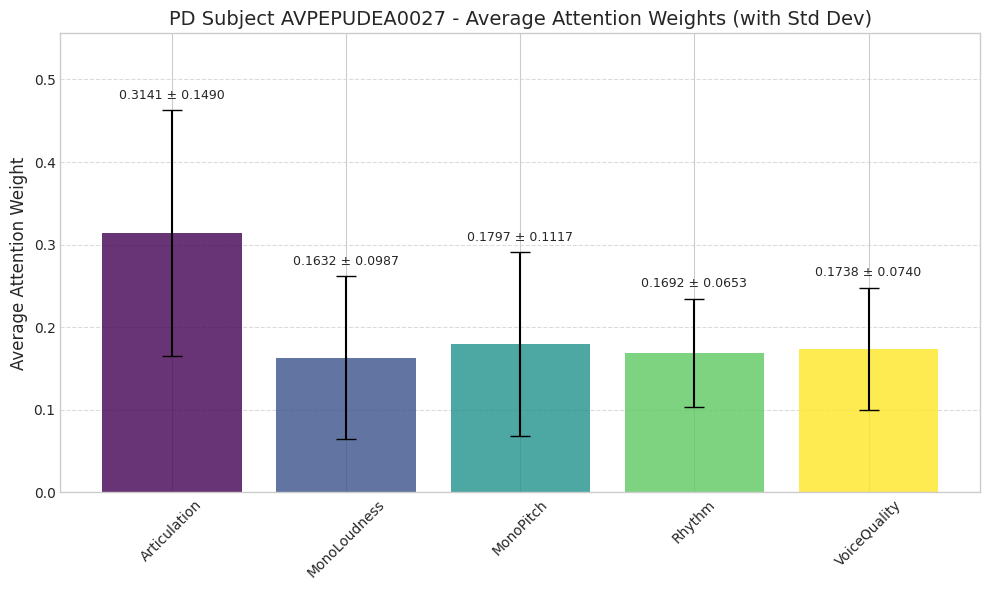


计算HC受试者平均注意力权重和标准差:
找到49个不同的受试者
处理受试者 AVPEPUDEAC0013，包含36个样本
处理受试者 AVPEPUDEAC0003，包含80个样本
处理受试者 AVPEPUDEAC0044，包含82个样本
处理受试者 AVPEPUDEAC0015，包含79个样本
处理受试者 AVPEPUDEAC0054，包含81个样本
处理受试者 AVPEPUDEAC0046，包含70个样本
处理受试者 AVPEPUDEAC0006，包含82个样本
处理受试者 AVPEPUDEAC0033，包含85个样本
处理受试者 AVPEPUDEAC0023，包含81个样本
处理受试者 AVPEPUDEAC0031，包含53个样本
处理受试者 AVPEPUDEAC0012，包含62个样本
处理受试者 AVPEPUDEAC0048，包含84个样本
处理受试者 AVPEPUDEAC0040，包含68个样本
处理受试者 AVPEPUDEAC0029，包含80个样本
处理受试者 AVPEPUDEAC0016，包含63个样本
处理受试者 AVPEPUDEAC0047，包含74个样本
处理受试者 AVPEPUDEAC0005，包含81个样本
处理受试者 AVPEPUDEAC0001，包含62个样本
处理受试者 AVPEPUDEAC0030，包含78个样本
处理受试者 AVPEPUDEAC0037，包含5个样本
处理受试者 AVPEPUDEAC0018，包含83个样本
处理受试者 AVPEPUDEAC0008，包含71个样本
处理受试者 AVPEPUDEAC0027，包含15个样本
处理受试者 AVPEPUDEAC0026，包含84个样本
处理受试者 AVPEPUDEAC0049，包含64个样本
处理受试者 AVPEPUDEAC0053，包含76个样本
处理受试者 AVPEPUDEAC0017，包含62个样本
处理受试者 AVPEPUDEAC0039，包含63个样本
处理受试者 AVPEPUDEAC0052，包含53个样本
处理受试者 AVPEPUDEAC0022，包含73个样本
处理受试者 AVPEPUDEAC0019，包含84个样本
处理受试者 AVPEPUDEAC0004，包含54个样本
处理受试者 AVPEPUDEAC0042，包含84个样本
处理受试者 AVPEP

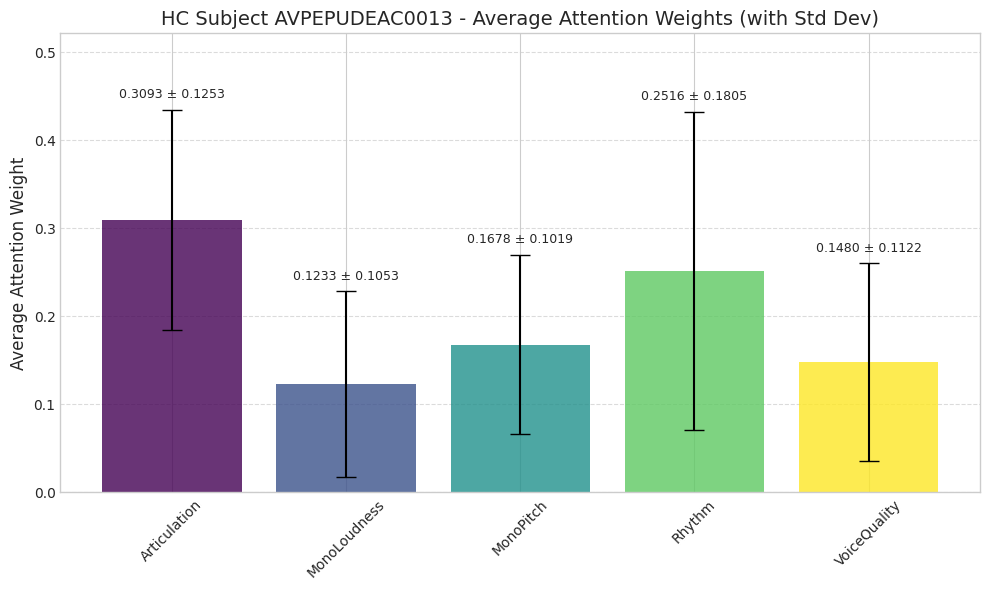

In [23]:
def get_subject_average_attention(attn_scores_list, sample_ids, dimension_names=None):
    """
    根据subject_id对样本进行分组，计算每个受试者的平均注意力权重和标准差
    
    参数:
        attn_scores_list: 样本注意力分数列表
        sample_ids: 样本ID列表
        dimension_names: 维度名称列表
    
    返回:
        subject_avg_scores: 受试者平均分数字典，key为subject_id，value为平均注意力权重
        subject_std_scores: 受试者标准差字典，key为subject_id，value为标准差
    """
    if dimension_names is None:
        dimension_names = ['Articulation', 'MonoLoudness', 'MonoPitch', 'Rhythm', 'VoiceQuality']
    
    # 根据subject_id进行分组
    subject_groups = {}
    for i, sample_id in enumerate(sample_ids):
        # 从sample_id中提取subject_id
        subject_id = sample_id.split('_')[-2]
        
        if subject_id not in subject_groups:
            subject_groups[subject_id] = []
        
        subject_groups[subject_id].append(i)
    
    print(f"找到{len(subject_groups)}个不同的受试者")
    
    # 为每个受试者计算平均注意力分数和标准差
    subject_avg_scores = {}
    subject_std_scores = {}  # 新增：记录每个受试者的标准差
    
    for subject_id, indices in subject_groups.items():
        print(f"处理受试者 {subject_id}，包含{len(indices)}个样本")
        
        # 收集该受试者的所有样本平均分数
        subject_samples_avg = []
        
        for idx in indices:
            attn_score = attn_scores_list[idx]
            
            # 识别非零区域（去除填充）
            row_sums = np.sum(np.abs(attn_score), axis=1)
            valid_rows = row_sums > 1e-10
            
            # 去除填充区域
            valid_sample = attn_score[valid_rows, :]
            
            # 计算单个样本的平均分数
            avg_scores = np.mean(valid_sample, axis=0)
            subject_samples_avg.append(avg_scores)
        
        # 将所有样本的分数转换为数组
        subject_samples_avg = np.array(subject_samples_avg)
        
        # 计算受试者的平均分数（多个样本的平均）
        subject_avg = np.mean(subject_samples_avg, axis=0)
        subject_avg_scores[subject_id] = subject_avg
        
        # 计算受试者所有样本的标准差
        if len(subject_samples_avg) > 1:  # 只有多个样本时才计算标准差
            subject_std = np.std(subject_samples_avg, axis=0)
        else:
            subject_std = np.zeros_like(subject_avg)  # 只有一个样本时，标准差为0
            
        subject_std_scores[subject_id] = subject_std
    
    return subject_avg_scores, subject_std_scores


def visualize_subject_attention_with_std(subject_id, subject_avg_scores, subject_std_scores, 
                                       dimension_names=None, condition="PD", output_path=None):
    """
    可视化单个受试者的平均注意力权重和标准差
    
    参数:
        subject_id: 要可视化的受试者ID
        subject_avg_scores: 所有受试者的平均分数字典
        subject_std_scores: 所有受试者的标准差字典
        dimension_names: 维度名称列表
        condition: 样本类型（HC或PD）
        output_path: 输出图像路径，如果为None则显示图像
    """
    if dimension_names is None:
        dimension_names = ['Articulation', 'MonoLoudness', 'MonoPitch', 'Rhythm', 'VoiceQuality']
    
    if subject_id not in subject_avg_scores:
        print(f"错误：找不到受试者ID {subject_id}")
        return
    
    avg_scores = subject_avg_scores[subject_id]
    std_scores = subject_std_scores[subject_id]
    
    # 设置绘图风格
    plt.style.use('seaborn-v0_8-whitegrid')
    colors = plt.cm.viridis(np.linspace(0, 1, len(dimension_names)))
    
    # 创建图形
    plt.figure(figsize=(10, 6))
    
    # 创建带有误差条的柱状图
    bars = plt.bar(dimension_names, avg_scores, color=colors, yerr=std_scores, 
                   capsize=7, alpha=0.8, ecolor='black')
    
    # 在每个柱状上方标注具体数值
    for bar, std in zip(bars, std_scores):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + std + 0.01,
                 f'{height:.4f} ± {std:.4f}', ha='center', va='bottom', fontsize=9)
    
    plt.title(f'{condition} Subject {subject_id} - Average Attention Weights (with Std Dev)', fontsize=14)
    plt.ylabel('Average Attention Weight', fontsize=12)
    plt.ylim(0, np.max(avg_scores + std_scores) * 1.2)  # 设置合适的y轴范围，考虑到标准差
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    
    # 保存或显示图像
    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    return avg_scores, std_scores

# 使用示例 - 修改代码调用部分
# 计算平均注意力权重与标准差
if len(pd_attn_scores) > 0:
    print("\n计算PD受试者平均注意力权重和标准差:")
    pd_subject_avg_scores, pd_subject_std_scores = get_subject_average_attention(
        pd_attn_scores,
        pd_sample_ids
    )
    
    # 可视化带标准差的PD受试者注意力权重
    if len(pd_subject_avg_scores) > 0:
        subject_id = list(pd_subject_avg_scores.keys())[0]  # 选择第一个受试者
        visualize_subject_attention_with_std(
            subject_id,
            pd_subject_avg_scores,
            pd_subject_std_scores,
            condition="PD",
            output_path=os.path.join(output_dir, 'figures', f'pd_subject_{subject_id}_with_std.png')
        )

# 计算HC受试者平均注意力权重与标准差
if len(hc_attn_scores) > 0:
    print("\n计算HC受试者平均注意力权重和标准差:")
    hc_subject_avg_scores, hc_subject_std_scores = get_subject_average_attention(
        hc_attn_scores,
        hc_sample_ids
    )
    
    # 可视化带标准差的HC受试者注意力权重
    if len(hc_subject_avg_scores) > 0:
        subject_id = list(hc_subject_avg_scores.keys())[0]  # 选择第一个受试者
        visualize_subject_attention_with_std(
            subject_id,
            hc_subject_avg_scores,
            hc_subject_std_scores,
            condition="HC",
            output_path=os.path.join(output_dir, 'figures', f'hc_subject_{subject_id}_with_std.png')
        )


比较PD受试者与HC平均值的差异:


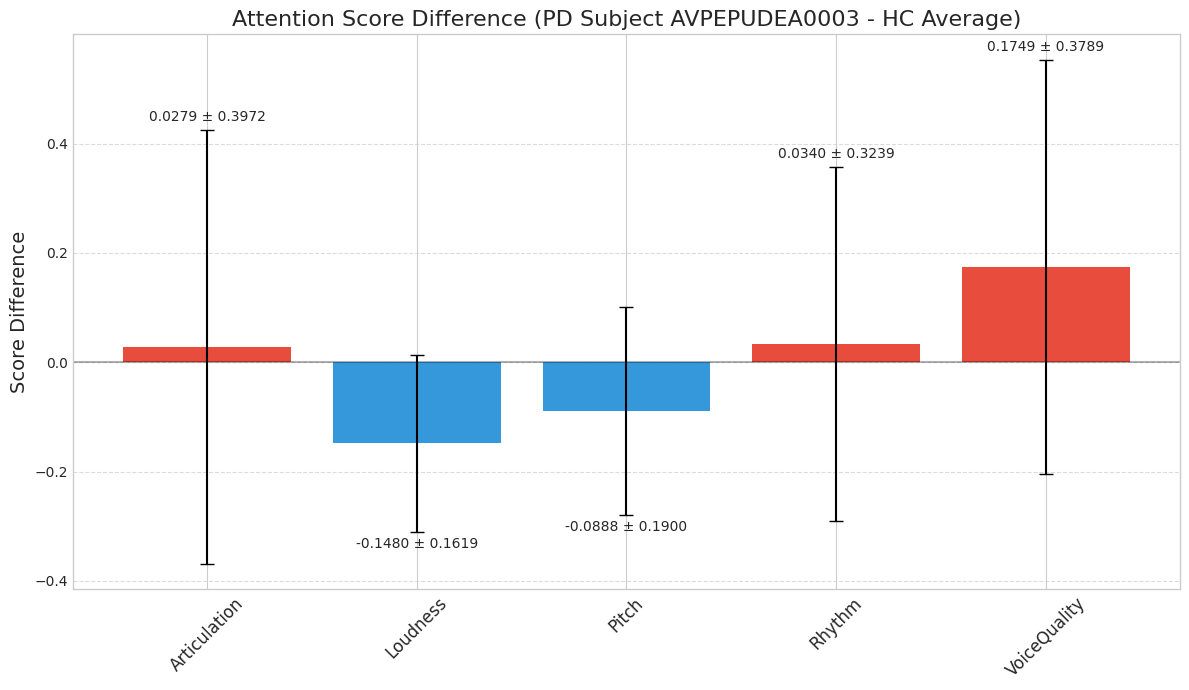

TypeError: unhashable type: 'list'

In [ ]:
def visualize_subject_difference_from_hc(subject_id, subject_avg_scores, subject_std_scores, hc_avg, hc_std=None, 
                                       dimension_names=None, condition="PD", output_path=None):
    """
    可视化单个受试者平均注意力权重与HC平均值之间的差异
    
    参数:
        subject_id: 要可视化的受试者ID
        subject_avg_scores: 所有受试者的平均分数字典
        subject_std_scores: 所有受试者的标准差字典
        hc_avg: HC样本的平均注意力分数
        hc_std: HC样本的标准差，可选
        dimension_names: 维度名称列表
        condition: 样本类型（如"PD"）
        output_path: 输出图像路径，如果为None则显示图像
    """
    if dimension_names is None:
        dimension_names = ['Articulation', 'MonoLoudness', 'MonoPitch', 'Rhythm', 'VoiceQuality']
        dimension_names = ['Articulation', 'Loudness', 'Pitch', 'Rhythm', 'VoiceQuality']
    
    if subject_id not in subject_avg_scores:
        print(f"错误：找不到受试者ID {subject_id}")
        return
    
    # 获取该受试者的平均注意力分数和标准差
    subject_avg = subject_avg_scores[subject_id]
    subject_std = subject_std_scores[subject_id]
    
    # 计算与HC平均值的差异
    diff = subject_avg - hc_avg
    
    # 设置颜色映射 - 红色表示高于HC平均，蓝色表示低于HC平均
    colors = ['#3498db' if d < 0 else '#e74c3c' for d in diff]
    
    # 创建图形 - 只有差异图
    plt.figure(figsize=(12, 7))
    
    # 画出差异柱状图
    bars = plt.bar(dimension_names, diff, color=colors)
    
    # 计算差异标准差（误差传播：两个独立随机变量的差的标准差）
    if hc_std is not None:
        diff_std = np.sqrt(np.power(subject_std, 2) + np.power(hc_std, 2))
    else:
        diff_std = subject_std
    
    # 添加差异标准差的误差条
    plt.errorbar(x=np.arange(len(dimension_names)), y=diff, yerr=diff_std, 
                fmt='none', ecolor='black', capsize=5)
    
    # 在差异值上标注具体数值
    for i, (bar, d, std) in enumerate(zip(bars, diff, diff_std)):
        height = bar.get_height()
        # 如果是负值，文本显示在柱状下方
        if height < 0:
            plt.text(bar.get_x() + bar.get_width()/2., height - std - 0.01,
                    f'{height:.4f} ± {std:.4f}', ha='center', va='top', fontsize=10)
        else:
            plt.text(bar.get_x() + bar.get_width()/2., height + std + 0.01,
                    f'{height:.4f} ± {std:.4f}', ha='center', va='bottom', fontsize=10)
    
    plt.title(f'Attention Score Difference ({condition} Subject {subject_id} - HC Average)', fontsize=16)
    plt.ylabel('Score Difference', fontsize=14)
    plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    plt.xticks(rotation=45, fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # # 如果提供了HC标准差，添加阴影区域表示HC样本的标准差范围
    # if hc_std is not None:
    #     for i, std in enumerate(hc_std):
    #         plt.fill_between([i-0.4, i+0.4], [-std, -std], [std, std],
    #                         color='gray', alpha=0.2)
    
    plt.tight_layout()
    
    # 保存或显示图像
    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    return subject_avg, diff, subject_std

# 更新后的使用方式:
if 'pd_subject_avg_scores' in locals() and 'pd_subject_std_scores' in locals() and 'hc_avg' in locals():
    print("\n比较PD受试者与HC平均值的差异:")
    # 为单个受试者创建差异图
    for idx in range(2, 3):  # 选择第11个到第20个受试者
        subject_id = list(pd_subject_avg_scores.keys())[idx]  # 选择第11个受试者
        visualize_subject_difference_from_hc(
            subject_id, 
            pd_subject_avg_scores,
            pd_subject_std_scores,  # 现在需要传入受试者的标准差
            hc_avg, 
            hc_std=hc_std,
            condition="PD",
            output_path=os.path.join(output_dir, 'figures', f'pd_subject_{subject_id}_vs_hc.png')
        )
visualize_subject_difference_from_hc(
            'AVPEPUDEA0015', 
            pd_subject_avg_scores,
            pd_subject_std_scores,  # 现在需要传入受试者的标准差
            hc_avg, 
            hc_std=hc_std,
            condition="PD",
            output_path=os.path.join(output_dir, 'figures', f'pd_subject_{subject_id}_vs_hc.png')
        )


In [26]:
def visualize_subject_heatmap(subject_avg_scores, dimension_names=None, 
                             condition="PD", output_path=None):
    """
    以热图形式可视化所有受试者的平均注意力分数
    
    参数:
        subject_avg_scores: 受试者平均分数字典
        dimension_names: 维度名称列表
        condition: 样本类型（HC或PD）
        output_path: 输出图像路径
    """
    if dimension_names is None:
        dimension_names = ['Articulation', 'MonoLoudness', 'MonoPitch', 'Rhythm', 'VoiceQuality']
    
    # 准备热图数据
    subject_ids = list(subject_avg_scores.keys())
    data_matrix = np.array([subject_avg_scores[sid] for sid in subject_ids])
    
    # 创建热图
    plt.figure(figsize=(12, len(subject_ids) * 0.4 + 2))
    
    # 使用自定义颜色映射，使中间值接近白色
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    
    # 绘制热图
    ax = sns.heatmap(data_matrix, cmap=cmap, center=0.2,
                    xticklabels=dimension_names, 
                    yticklabels=[f"Subject {sid}" for sid in subject_ids],
                    annot=True, fmt=".3f", linewidths=.5)
    
    plt.title(f'{condition} Subjects - Average Attention Weights per Dimension', fontsize=14)
    plt.tight_layout()
    
    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.show()

# 在计算完受试者平均值后应用热图可视化
if 'pd_subject_avg' in locals():
    visualize_subject_heatmap(
        pd_subject_avg,
        condition="PD",
        output_path=os.path.join(output_dir, 'figures', 'pd_subject_heatmap.png')
    )

# if 'hc_subject_avg' in locals():
#     visualize_subject_heatmap(
#         hc_subject_avg,
#         condition="HC",
#         output_path=os.path.join(output_dir, 'figures', 'hc_subject_heatmap.png')
#     )


创建PD受试者与HC平均值差异的热图:


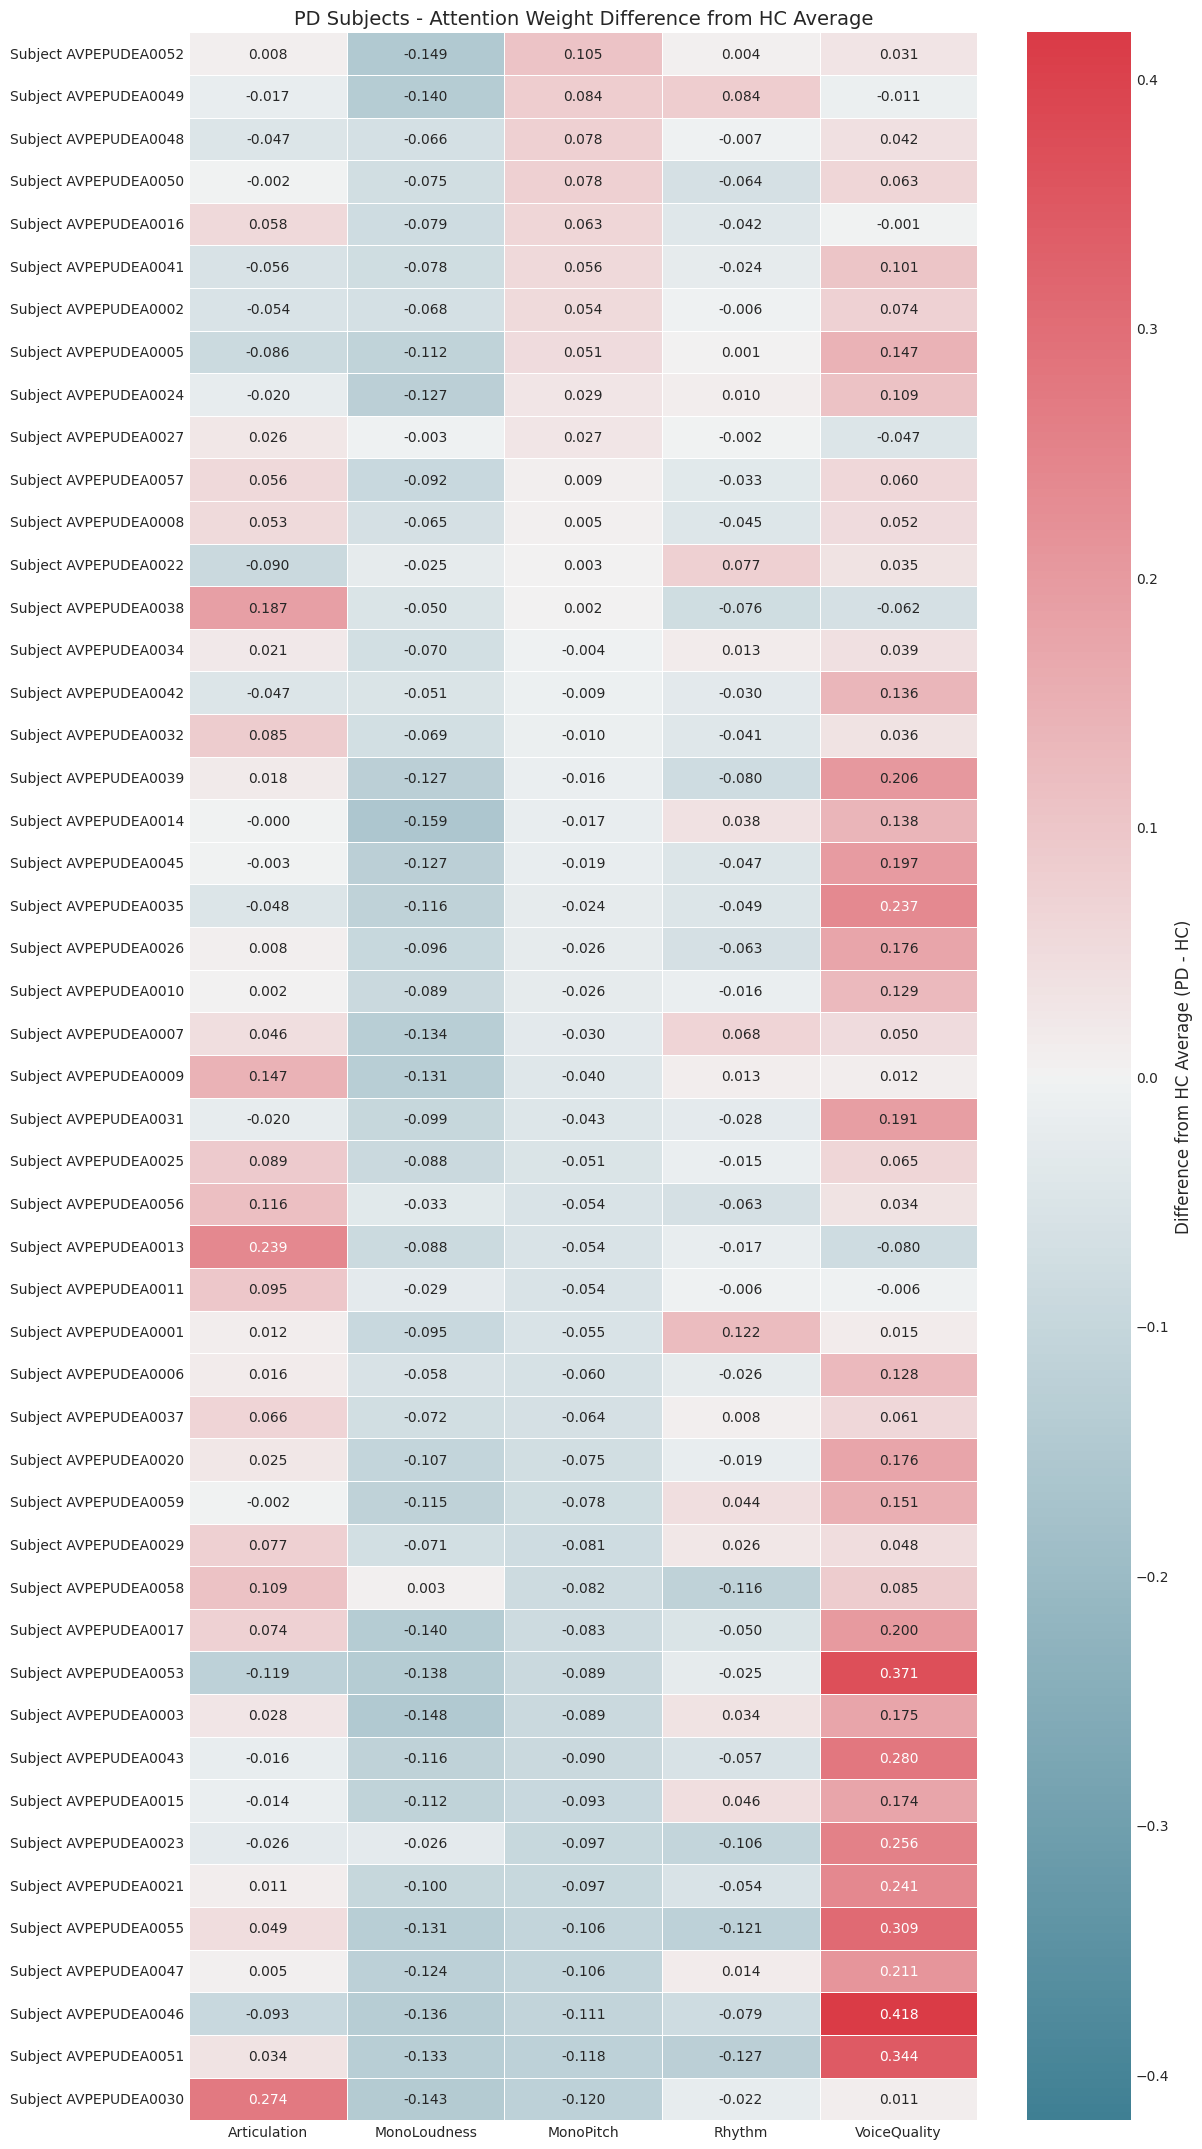

差异的最大值: 0.4183
差异的最小值: -0.1586
差异的平均值: 0.0000
差异的标准差: 0.1012

各维度上高于/低于HC平均值的受试者数量:
Articulation: 高于HC: 30, 低于HC: 19
Loudness: 高于HC: 1, 低于HC: 48
Pitch: 高于HC: 14, 低于HC: 35
Rhythm: 高于HC: 16, 低于HC: 33
VoiceQuality: 高于HC: 43, 低于HC: 6


In [28]:
def visualize_difference_heatmap(subject_avg_scores, hc_avg, dimension_names=None,
                                condition="PD", sort_by_dimension=None, output_path=None):
    """
    以热图形式可视化所有受试者的注意力分数与HC平均值的差异
    
    参数:
        subject_avg_scores: 受试者平均分数字典
        hc_avg: HC样本的平均注意力分数
        dimension_names: 维度名称列表
        condition: 样本类型（通常是"PD"）
        sort_by_dimension: 可选，按某个维度的差异值对受试者排序
        output_path: 输出图像路径
    """
    if dimension_names is None:
        dimension_names = ['Articulation', 'MonoLoudness', 'MonoPitch', 'Rhythm', 'VoiceQuality']
    
    # 准备热图数据
    subject_ids = list(subject_avg_scores.keys())
    
    # 计算每个受试者与HC平均值的差异
    diff_matrix = np.array([subject_avg_scores[sid] - hc_avg for sid in subject_ids])
    
    # 如果需要按某个维度排序
    if sort_by_dimension is not None and sort_by_dimension in dimension_names:
        dim_idx = dimension_names.index(sort_by_dimension)
        # 按照指定维度的差异值从大到小排序
        sorted_indices = np.argsort(diff_matrix[:, dim_idx])[::-1]
        diff_matrix = diff_matrix[sorted_indices]
        sorted_subject_ids = [subject_ids[i] for i in sorted_indices]
    else:
        sorted_subject_ids = subject_ids
    
    # 计算差异的范围，用于设置颜色映射的中心点
    max_abs_diff = np.max(np.abs(diff_matrix))
    vmin = -max_abs_diff
    vmax = max_abs_diff
    
    # 创建热图
    plt.figure(figsize=(12, len(sorted_subject_ids) * 0.4 + 2))
    
    # 使用红蓝对比色映射，红色表示高于HC平均，蓝色表示低于HC平均
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    
    # 绘制热图
    ax = sns.heatmap(diff_matrix, cmap=cmap, center=0, vmin=vmin, vmax=vmax,
                    xticklabels=dimension_names, 
                    yticklabels=[f"Subject {sid}" for sid in sorted_subject_ids],
                    annot=True, fmt=".3f", linewidths=.5)
    
    # 添加颜色条的标签
    cbar = ax.collections[0].colorbar
    cbar.set_label(f'Difference from HC Average ({condition} - HC)', fontsize=12)
    
    plt.title(f'{condition} Subjects - Attention Weight Difference from HC Average', fontsize=14)
    plt.tight_layout()
    
    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    # 返回差异矩阵和对应的受试者ID，方便后续分析
    return diff_matrix, sorted_subject_ids

# 使用示例
dimension_names = ['Articulation', 'Loudness', 'Pitch', 'Rhythm', 'VoiceQuality']

if 'pd_subject_avg_scores' in locals() and 'hc_avg' in locals():
    print("\n创建PD受试者与HC平均值差异的热图:")
    
    # 可以按某个维度排序，例如按"Articulation"维度的差异排序
    diff_matrix, sorted_subjects = visualize_difference_heatmap(
        pd_subject_avg_scores,
        hc_avg,
        sort_by_dimension="MonoPitch",  # 按MonoPitch维度差异排序，可以改为任意维度或None
        condition="PD",
        output_path=os.path.join(output_dir, 'figures', 'pd_hc_difference_heatmap.png')
    )
    
    # 可以进一步分析差异的统计特性
    print(f"差异的最大值: {np.max(diff_matrix):.4f}")
    print(f"差异的最小值: {np.min(diff_matrix):.4f}")
    print(f"差异的平均值: {np.mean(diff_matrix):.4f}")
    print(f"差异的标准差: {np.std(diff_matrix):.4f}")
    
    # 统计在各维度上高于/低于HC平均值的受试者比例
    higher_than_hc = np.sum(diff_matrix > 0, axis=0)
    lower_than_hc = np.sum(diff_matrix < 0, axis=0)
    print("\n各维度上高于/低于HC平均值的受试者数量:")
    for i, dim in enumerate(dimension_names):
        print(f"{dim}: 高于HC: {higher_than_hc[i]}, 低于HC: {lower_than_hc[i]}")
        
        


显示每个维度差异最大的受试者:
维度 Articulation: 受试者 AVPEPUDEA0030 差异值 = 0.2744 (原值 = 0.5629, HC平均 = 0.2885)
维度 Articulation: 受试者 AVPEPUDEA0013 差异值 = 0.2394 (原值 = 0.5279, HC平均 = 0.2885)
维度 Loudness: 受试者 AVPEPUDEA0058 差异值 = 0.0034 (原值 = 0.1701, HC平均 = 0.1666)
维度 Loudness: 受试者 AVPEPUDEA0027 差异值 = -0.0035 (原值 = 0.1632, HC平均 = 0.1666)
维度 Pitch: 受试者 AVPEPUDEA0052 差异值 = 0.1051 (原值 = 0.2580, HC平均 = 0.1530)
维度 Pitch: 受试者 AVPEPUDEA0049 差异值 = 0.0844 (原值 = 0.2373, HC平均 = 0.1530)
维度 Rhythm: 受试者 AVPEPUDEA0001 差异值 = 0.1217 (原值 = 0.2927, HC平均 = 0.1710)
维度 Rhythm: 受试者 AVPEPUDEA0049 差异值 = 0.0837 (原值 = 0.2547, HC平均 = 0.1710)
维度 VoiceQuality: 受试者 AVPEPUDEA0046 差异值 = 0.4183 (原值 = 0.6392, HC平均 = 0.2209)
维度 VoiceQuality: 受试者 AVPEPUDEA0053 差异值 = 0.3709 (原值 = 0.5917, HC平均 = 0.2209)


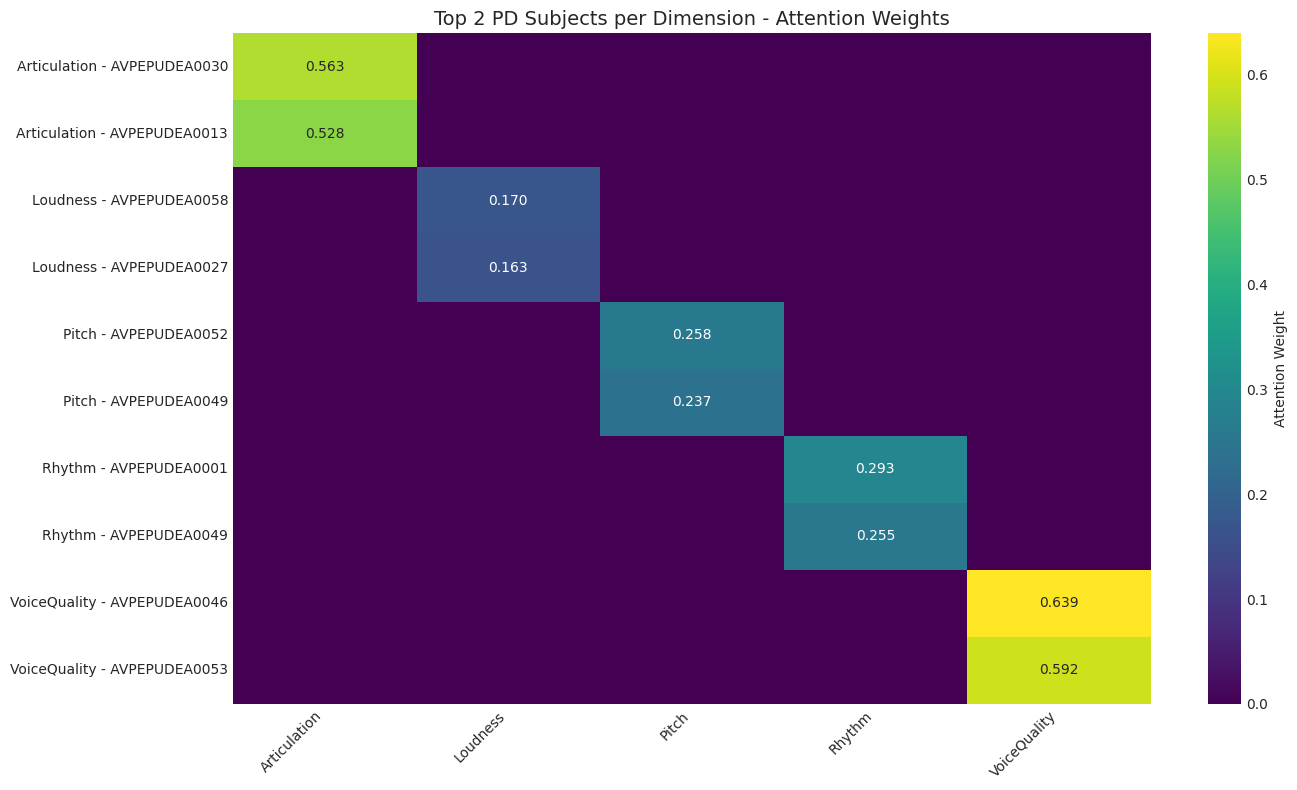

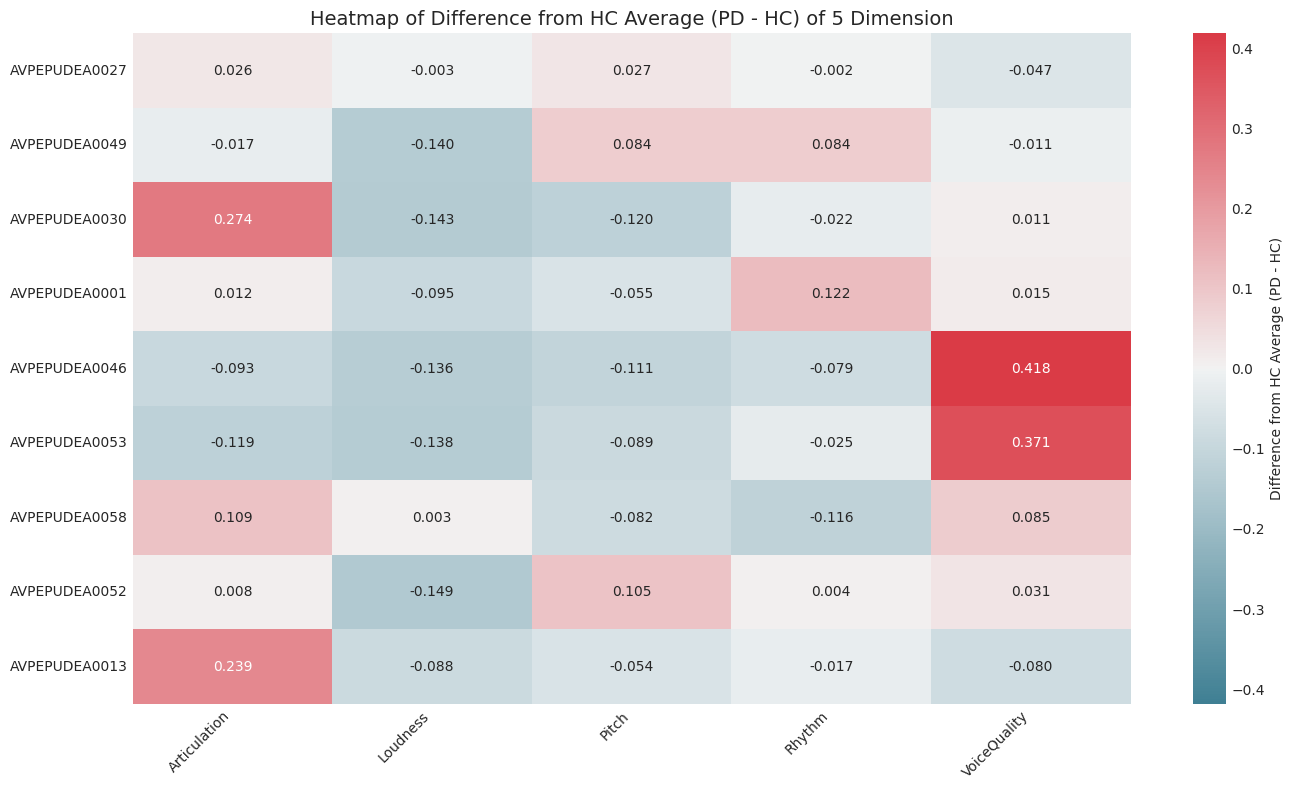

In [37]:
def visualize_top_subjects_by_dimension(subject_avg_scores, hc_avg, dimension_names=None,
                                       n_subjects=2, condition="PD", output_path=None):
    """
    为每个维度找出与HC差异最大的n个受试者并以两张独立热图形式可视化
    
    参数:
        subject_avg_scores: 受试者平均分数字典，key为subject_id，value为平均注意力权重
        hc_avg: HC样本的平均注意力分数
        dimension_names: 维度名称列表
        n_subjects: 每个维度要选择的受试者数量
        condition: 样本类型（通常是"PD"）
        output_path: 输出图像路径的基础部分（不含扩展名）
    """
    if dimension_names is None:
        dimension_names = ['Articulation', 'MonoLoudness', 'MonoPitch', 'Rhythm', 'VoiceQuality']
    
    # 准备数据
    subject_ids = list(subject_avg_scores.keys())
    subject_data = np.array([subject_avg_scores[sid] for sid in subject_ids])
    
    # 计算每个受试者与HC平均值的差异
    diff_matrix = subject_data - hc_avg
    abs_diff_matrix = np.abs(diff_matrix)  # 差异的绝对值
    
    # 为每个维度找出差异最大的n个受试者
    selected_subjects = {}
    selected_values = {}
    selected_diffs = {}
    
    for dim_idx, dim_name in enumerate(dimension_names):
        # 对该维度的受试者差异进行排序
        sorted_indices = np.argsort(diff_matrix[:, dim_idx])[::-1]  # 从大到小排序
        
        # 选择前n个差异最大的受试者
        top_indices = sorted_indices[:n_subjects]
        
        selected_subjects[dim_name] = []
        selected_values[dim_name] = []
        selected_diffs[dim_name] = []
        
        for idx in top_indices:
            subject_id = subject_ids[idx]
            diff_value = diff_matrix[idx, dim_idx]
            actual_value = subject_data[idx, dim_idx]
            
            selected_subjects[dim_name].append(subject_id)
            selected_values[dim_name].append(actual_value)
            selected_diffs[dim_name].append(diff_value)
            
            print(f"维度 {dim_name}: 受试者 {subject_id} 差异值 = {diff_value:.4f} (原值 = {actual_value:.4f}, HC平均 = {hc_avg[dim_idx]:.4f})")
    
    # 创建两个独立的热图 - 第1个：原始值
    plt.figure(figsize=(14, 8))
    data = []
    annotations = []
    row_labels = []
    subject_indices = {}  # 记录每个subject_id对应的索引
    
    for dim_name in dimension_names:
        for i, (subject_id, value) in enumerate(zip(selected_subjects[dim_name], selected_values[dim_name])):
            data.append([0]*len(dimension_names))  # 初始化为全0行
            data[-1][dimension_names.index(dim_name)] = value  # 仅在对应维度设置值
            
            # 准备注释文本
            annotations.append(['' for _ in dimension_names])
            annotations[-1][dimension_names.index(dim_name)] = f'{value:.3f}'
            
            # 行标签: 维度名 - 受试者ID
            row_labels.append(f"{dim_name} - {subject_id}")
            
            # 记录该subject_id
            subject_indices[subject_id] = len(data) - 1
    
    # 转换为numpy数组
    data_array = np.array(data)
    
    # 创建热图
    cmap1 = plt.cm.viridis
    ax = sns.heatmap(data_array, annot=annotations, cmap=cmap1, fmt="", 
                     xticklabels=dimension_names, yticklabels=row_labels,
                     cbar_kws={'label': 'Attention Weight'})
    
    # 调整布局
    plt.title(f'Top {n_subjects} {condition} Subjects per Dimension - Attention Weights', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    
    # 保存图像
    if output_path:
        weight_path = f"{output_path}_weights.png" if ".png" not in output_path else output_path.replace(".png", "_weights.png")
        plt.savefig(weight_path, dpi=300, bbox_inches='tight')
    plt.show()

    # 创建两个独立的热图 - 第2个：完整的差异值热图
    # 与第一个图不同，这里我们为每个受试者显示所有维度的差异值
    plt.figure(figsize=(14, 8))
    
    # 准备差异热图数据 - 这次我们要显示所有维度的差异
    diff_matrix_for_heatmap = []
    unique_subjects = set()
    for dim_name in dimension_names:
        for subject_id in selected_subjects[dim_name]:
            unique_subjects.add(subject_id)
    
    # 为每个唯一的受试者创建一行数据
    unique_heatmap_rows = []
    unique_row_labels = []
    
    for subject_id in unique_subjects:
        # 获取该受试者的完整差异值
        subject_idx = subject_ids.index(subject_id)
        complete_diff = diff_matrix[subject_idx]
        
        # 找出该受试者在哪些维度上是Top差异
        top_dimensions = []
        for dim_name, subjects in selected_subjects.items():
            if subject_id in subjects:
                top_dimensions.append(dim_name)
        
        # 添加到热图数据
        unique_heatmap_rows.append(complete_diff)
        # 行标签显示此受试者在哪些维度上是Top
        unique_row_labels.append(f"{subject_id}")
    
    # 转换为numpy数组
    diff_complete_array = np.array(unique_heatmap_rows)
    
    # 获取差异的绝对值最大值用于颜色映射
    max_abs = np.max(np.abs(diff_complete_array))
    
    # 创建热图 - 显示完整差异
    cmap2 = sns.diverging_palette(220, 10, as_cmap=True)
    ax = sns.heatmap(diff_complete_array, cmap=cmap2, fmt=".3f", center=0,
                     vmin=-max_abs, vmax=max_abs, xticklabels=dimension_names, 
                     yticklabels=unique_row_labels, annot=True,
                     cbar_kws={'label': f'Difference from HC Average ({condition} - HC)'})
    
    # 调整布局
    plt.title(f'Heatmap of Difference from HC Average ({condition} - HC) of 5 Dimension', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    
    # 保存图像
    if output_path:
        diff_path = f"{output_path}_diffs.png" if ".png" not in output_path else output_path.replace(".png", "_diffs.png")
        plt.savefig(diff_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    # 返回选中的数据，方便进一步分析
    return selected_subjects, selected_values, selected_diffs

# 使用示例 - 如果已有必需的变量
if 'pd_subject_avg_scores' in locals() and 'hc_avg' in locals():
    dimension_names = ['Articulation', 'Loudness', 'Pitch', 'Rhythm', 'VoiceQuality']
    
    print("\n显示每个维度差异最大的受试者:")
    top_subjects, top_values, top_diffs = visualize_top_subjects_by_dimension(
        pd_subject_avg_scores,
        hc_avg,
        dimension_names=dimension_names,
        n_subjects=2,  # 每个维度选择2个差异最大的受试者
        condition="PD",
        output_path=os.path.join(output_dir, 'figures', 'top_diff_subjects_heatmap')
    )